In [157]:
import numpy as np # 
import pandas as pd # For working with spreadsheet data
from matplotlib import pyplot as plt # For plotting data
import matplotlib.dates as mdates
import datetime

# ML Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# For hyperparameter optimization
import optuna

In [195]:
# Getting the spreadsheet data
data = pd.read_csv("Ethereum Data/ETH_5Years.csv")

In [196]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,207.485992,1749300000
...,...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,1810.088623,7534051038


# Cleaning the Data

In [198]:
# Deleting this row since it isn't important here
data.drop(['Adj Close'], axis = 1, inplace = True)

In [199]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


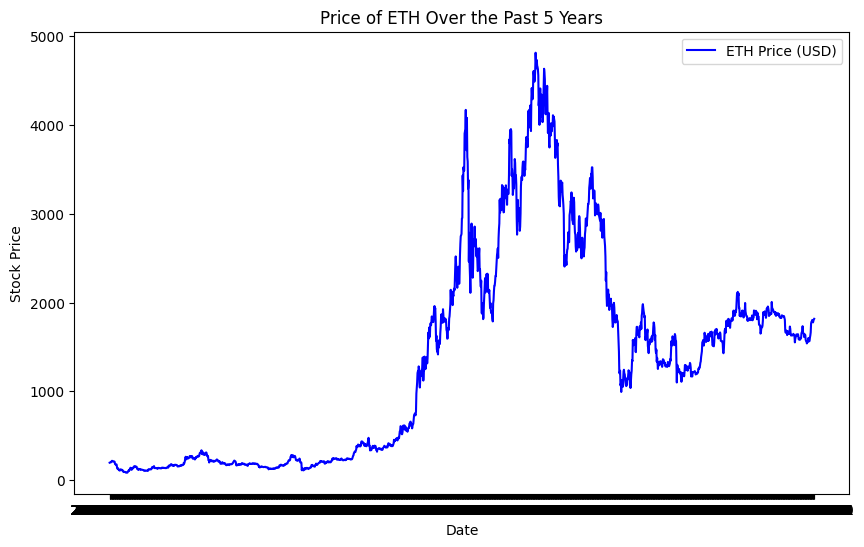

In [200]:
# Plotting ETH price
plt.figure(figsize = (10, 6))
plt.plot(data['Date'], data['Close'], label = "ETH Price (USD)", color = "blue")

plt.title("Price of ETH Over the Past 5 Years")
plt.xlabel("Date")
plt.xticks()
plt.ylabel("Stock Price")
plt.legend()

plt.show()

In [201]:
data['Close']

0        197.380997
1        198.871994
2        200.634995
3        200.186005
4        207.485992
           ...     
1822    1780.045288
1823    1776.618164
1824    1795.546021
1825    1810.088623
1826    1816.458984
Name: Close, Length: 1827, dtype: float64

In [202]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


In [203]:
# Creating a constant to store the number of days in the future to predict the price
DAYS_IN_FUTURE = 3
length = len(data)

# Adding an extra column for the future price and setting the value of each row equal to the 'Close' value DAYS_IN_FUTURE days in the future
future_price = [data['Close'].loc[x + DAYS_IN_FUTURE] for x in range(length - DAYS_IN_FUTURE)]

# Getting rid of last DAYS_IN_FUTURE rows since there is no future price value for those days
for x in range(DAYS_IN_FUTURE):
    data.drop(length - x - 1, inplace = True)

In [204]:
# Creating the column in the DataFrame
data[f"{DAYS_IN_FUTURE} Days Future Price"] = future_price
data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,2023-10-24,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,2023-10-25,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,2023-10-26,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


In [205]:
# Converting the date value to an integer so it can be used by the model
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(mdates.date2num)
data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,19654.0,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,19655.0,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,19656.0,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


# Preparing the Data

In [206]:
# Storing the independent variables and dependent variable
features = data['Date'].values
target = data[f'{DAYS_IN_FUTURE} Days Future Price'].values

In [207]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.35)

In [ ]:
# y_train_reshaped = np.ravel(y_train)
# x_train

In [208]:
# Scale the features data for preprocessing
scaler = MinMaxScaler(feature_range = (0, 1))

x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Hyperparameter Optimization

In [217]:
# Train the SVR model in a way that optimizes the model's hyperparameters
def optimize_svr(trial):
    # Suggesting possible values to test for each hyperparameter
    c = trial.suggest_float("C", 1000, 5000, log = True)
    gamma = trial.suggest_float("gamma", 1e-5, 1e-1, log = True)
    
    # Creating the model to use for testing
    model = SVR(kernel = 'rbf', C = c, gamma = gamma)
    # Calculate how well a given model with certain hyperparameter performs
    score = np.mean(cross_val_score(model, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    accuracy = score.mean()
    
    # The metric being used to determine how effective a model is with certain hyperparameters
    return accuracy

In [218]:
# Creating the study object
study = optuna.create_study(direction = 'maximize')
# Experimenting with different hyperparameter values to find the optimal values
study.optimize(optimize_svr, n_trials = 100)

# Information about the most successful trial
print("Best trial:")
trial = study.best_trial

# The model hyperparameters that lead to maximum accuracy
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-13 12:27:46,067] A new study created in memory with name: no-name-771a51f9-2a69-4f6c-9d44-f7bddc8e1591
[I 2023-11-13 12:27:46,375] Trial 0 finished with value: -1292923.6555697385 and parameters: {'C': 3430.142895724148, 'gamma': 0.00016507930785333408}. Best is trial 0 with value: -1292923.6555697385.
[I 2023-11-13 12:27:46,684] Trial 1 finished with value: -993166.3898659702 and parameters: {'C': 2888.1689116880766, 'gamma': 0.0075844490677493695}. Best is trial 1 with value: -993166.3898659702.
[I 2023-11-13 12:27:47,025] Trial 2 finished with value: -1109911.2664716197 and parameters: {'C': 2629.684774975771, 'gamma': 0.001534289211024864}. Best is trial 1 with value: -993166.3898659702.
[I 2023-11-13 12:27:47,308] Trial 3 finished with value: -977812.0949540485 and parameters: {'C': 1594.2552362603897, 'gamma': 0.03476051047928404}. Best is trial 3 with value: -977812.0949540485.
[I 2023-11-13 12:27:47,687] Trial 4 finished with value: -958234.5146271817 and parameters:

Best trial:
Value: -910911.697684098
Params:
    C: 4941.71367916335
    gamma: 0.0989339395906186


In [219]:
# Getting the best values of each hyperparameter 
params = study.best_params

# Building and Running the Model

In [220]:
def build_model():
    # Passing in optimal hyperparameters
    model = SVR(kernel = 'rbf', C = params['C'], gamma = params['gamma'])
    # scaler_target = MinMaxScaler(feature_range=(0, 1))
    # y_train_reshaped_scaled = scaler_target.fit_transform(y_train_reshaped.reshape(-1, 1)).ravel()
    # Fitting the model to the training data set
    model.fit(x_train_scaled, y_train)
    
    return model

In [221]:
# Creating the model
model = build_model()

In [222]:
# Testing the model on the test set
predictions = model.predict(x_test_scaled)

In [223]:
# Evaluating its performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
conf = model.score(x_test_scaled, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Accuracy: {conf}")

Mean Squared Error: 971462.3273365076
R-squared: 0.3250806976560554
Accuracy: 0.3250806976560554


In [70]:
print(predictions)
print("--------------------------------------")
print(y_test)

[1284.28632104 1282.01740317 1284.41045582 1279.87261404 1280.5174298
 1283.14496767 1279.9519229  1279.99330143 1278.42436834 1281.94154247
 1282.58290987 1278.44505751 1283.2553102  1281.53120498 1278.36574902
 1279.68641069 1279.25193653 1279.158835   1283.24496559 1281.50017105
 1278.21058032 1280.81052804 1279.47262176 1280.75190839 1278.70712053
 1282.17602096 1284.21735725 1278.22437309 1282.52084209 1279.18297243
 1280.34846733 1280.55536016 1283.88288253 1278.91401256 1284.06563682
 1281.95878354 1280.23467629 1279.35193451 1283.68633531 1284.01046573
 1283.32427426 1278.25540682 1279.86226941 1284.07253321 1283.45530594
 1278.83470393 1279.71054816 1283.47254694 1284.01736212 1283.38979011
 1281.37948353 1279.00366583 1281.92774962 1284.23804639 1280.63122088
 1278.46229849 1281.60361749 1280.37605304 1283.13117485 1283.2587584
 1279.86571762 1278.60022637 1281.42431032 1280.98983522 1279.02780325
 1280.56915302 1280.13122991 1283.13807126 1280.88638877 1280.42777624
 1282.91

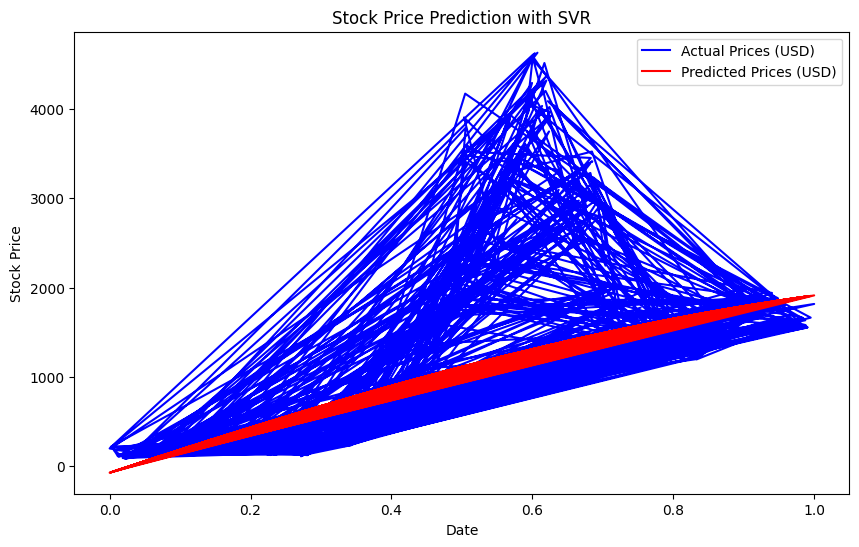

In [224]:
# Plotting performance
plt.figure(figsize = (10, 6))
plt.plot(x_test_scaled, y_test, label = "Actual Prices (USD)", color = "blue")
plt.plot(x_test_scaled, predictions, label = "Predicted Prices (USD)", color = "red")

plt.title("Stock Price Prediction with SVR")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()

plt.show()

Not too impressive, could be overfitting?
Let's see if an LSTM RNN performs better